In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from utility import calculate_input_gradients, perturb_inputs, preprocess_images, \
                    extract_features, postprocess_features, save_data_hdf5, get_dataset_hdf5, \
                    build_one_class_svm, combine_inliners_outliers, extract_all_features,\
                    extract_layer_features
from utility_db_outliers import load_dataset
from models_lib import load_custom_model_for_ds
import h5py
from general_setting import *
from metrics import *
from matplotlib.ticker import FuncFormatter
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import scipy.io as sio

In [14]:
FEA_LOC="./features/"     #The folder in which extracted features are saved.
if not os.path.isdir(FEA_LOC): os.makedirs(FEA_LOC)
BATCH_SIZE = 1000
id_name=ID_DS_LIST[1]     # selects the ID dataset.
id_model=ID_MODEL_LIST[2] # select the deep model used for training ID dataset.
print(id_name,"->", id_model)

CIFAR10 -> ResNet


In [15]:
# We specified the index of layers for several architectures we explored in our experiement.
# you can make it to be done automatically or chane the index to suit your architecture.

if id_name=="MNIST" and id_model=="LeNet":
    OOD_DS_LIST       = OOD_DS_LIST_MNIST
    slc_layers     = (0,1,2,3,6,7,8)
    #**********************************************************
elif id_name=="CIFAR10":
    OOD_DS_LIST       = OOD_DS_LIST_CIFAR10
    if id_model=="VGG":
        slc_layers = (0,3,5,6,9,11,12,15,18,20,21,24,27,30,33,36,38)
    elif id_model=="ResNet":
        slc_layers = (3,6,10,13,17,20,24,27,31,34,38,41,45,48,52,55,60,63,67,70,74,77,81,84,88,91,95,98,102,105,110,113,117,120,124,127,131,134,138,141,145,148,152)        
    #**********************************************************
elif id_name=="SVHN":
    OOD_DS_LIST       = OOD_DS_LIST_CIFAR10
    if id_model=="VGG":
        slc_layers = (0,3,5,6,9,11,12,15,18,20,21,24,27,30,33,36,38)
    elif id_model=="ResNet":
        slc_layers = (3,6,10,13,17,20,24,27,32,35,39,42,46,49,54,57,61,64,68)        
    #**********************************************************

In [16]:
model = load_custom_model_for_ds(id_name, id_model)
# model.summary()

The ResNet-V1-44 model for CIFAR10 was loaded.


In [17]:
(train_images,_),(test_images, y_test) = load_dataset(id_name)
train_img_processed=preprocess_images(id_name, train_images, id_model, verbose=True)
test_img_processed=preprocess_images(id_name, test_images, id_model, verbose=True)

D:\software\Anaconda\envs\tf-gpu2\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Preprocessing was done for  CIFAR10 ResNet
Preprocessing was done for  CIFAR10 ResNet


In [18]:
y_test=to_categorical(y_test, 10)
sc = model.evaluate(test_img_processed, y_test)
print(sc)

10000/10000 [==============================] - 14s 1ms/sample - loss: 0.4968 - accuracy: 0.9165
[0.49680973229408265, 0.9165]


In [19]:
# id_model = 'newood'
base_address=FEA_LOC+"/"+id_name+"-"+id_model+"/"
if not os.path.isdir(base_address): os.makedirs(base_address)

file_address_train =base_address+"TRAIN"
if not os.path.isfile(file_address_train+".hdf5"):
    print("Extracting features for the training set")
    extract_all_features(model, train_img_processed, slc_layers, BATCH_SIZE, file_address_train)
     
else:
    print("The train set features are available.") 
    
file_address_test =base_address+"TEST"
if not os.path.isfile(file_address_test+".hdf5"):
    print("Extracting features for the test set")
    extract_all_features(model, test_img_processed, slc_layers, BATCH_SIZE, file_address_test)
else:
    print("The test set features are available.")

Extracting features for the training set
The featurs of layer 3 was saved. The shape of saved features is (50000, 16)
The featurs of layer 6 was saved. The shape of saved features is (50000, 16)
The featurs of layer 10 was saved. The shape of saved features is (50000, 16)
The featurs of layer 13 was saved. The shape of saved features is (50000, 16)
The featurs of layer 17 was saved. The shape of saved features is (50000, 16)
The featurs of layer 20 was saved. The shape of saved features is (50000, 16)
The featurs of layer 24 was saved. The shape of saved features is (50000, 16)
The featurs of layer 27 was saved. The shape of saved features is (50000, 16)
The featurs of layer 31 was saved. The shape of saved features is (50000, 16)
The featurs of layer 34 was saved. The shape of saved features is (50000, 16)
The featurs of layer 38 was saved. The shape of saved features is (50000, 16)
The featurs of layer 41 was saved. The shape of saved features is (50000, 16)
The featurs of layer 45 w

In [20]:
ood_ds_name = OOD_DS_LIST[0] # selects the OOD dataset used for finding the OODL.
print("The name of OOD dataset is "+ ood_ds_name)

The name of OOD dataset is TINYIMAGENET_RESIZED_32


In [21]:
(_,_),(outlier_data, _) = load_dataset(ood_ds_name)
outlier_data_processed = preprocess_images(id_name, outlier_data, id_model, verbose=True)
file_address_ood =base_address+ood_ds_name
if not os.path.isfile(file_address_ood+".hdf5"):
    print("Extracting features for the OOD datasets")
    extract_all_features(model, outlier_data_processed, slc_layers, BATCH_SIZE, file_address_ood)
else:
    print("The OOD set features are available.")

Preprocessing was done for  CIFAR10 ResNet
Extracting features for the OOD datasets
The featurs of layer 3 was saved. The shape of saved features is (10000, 16)
The featurs of layer 6 was saved. The shape of saved features is (10000, 16)
The featurs of layer 10 was saved. The shape of saved features is (10000, 16)
The featurs of layer 13 was saved. The shape of saved features is (10000, 16)
The featurs of layer 17 was saved. The shape of saved features is (10000, 16)
The featurs of layer 20 was saved. The shape of saved features is (10000, 16)
The featurs of layer 24 was saved. The shape of saved features is (10000, 16)
The featurs of layer 27 was saved. The shape of saved features is (10000, 16)
The featurs of layer 31 was saved. The shape of saved features is (10000, 16)
The featurs of layer 34 was saved. The shape of saved features is (10000, 16)
The featurs of layer 38 was saved. The shape of saved features is (10000, 16)
The featurs of layer 41 was saved. The shape of saved featur

In [22]:
from sklearn.metrics import roc_auc_score

In [23]:
def fpr_at_95_tpr(scores, labels):
    sc = scores
    lens = int(scores.shape[0] / 2)
    recall_point =0.95
    labels1 = np.asarray(labels[0:lens])
    scores1 = np.asarray(scores[0:lens])         
    sorted_scores = sorted(scores1,reverse=True) 
    n_thresh = recall_point * lens
    FP = 0
    TN = 0
    for i in range(lens,scores.shape[0]):
        if (sc[i]>=sorted_scores[int(n_thresh)-1]):
             FP += 1
        else:
            TN += 1    
    TP = 0
    FN = 0
    for i in range(lens):
        if (sc[i]>=sorted_scores[int(n_thresh)-1]):
             TP += 1
        else:
            FN += 1
    fpr =float(FP) / float(FP + TN+ 1e-7)
    return fpr


def detection_error(scores, labels):
    sc = scores
    lens = int(scores.shape[0] / 2)
    recall_point =0.95
    labels1 = np.asarray(labels[0:lens])
    scores1 = np.asarray(scores[0:lens])
    sorted_scores = sorted(scores1,reverse=True) 
    n_thresh = recall_point * lens
    FP = 0
    TN = 0
    for i in range(lens,scores.shape[0]):
        if (sc[i]>=sorted_scores[int(n_thresh)-1]):
             FP += 1
        else:
            TN += 1    
    TP = 0
    FN = 0
    for i in range(lens):
        if (sc[i]>=sorted_scores[int(n_thresh)-1]):
             TP += 1
        else:
            FN += 1
 
    _detection_error = (1.0- float(TP) / float(TP + FN+ 1e-7)+ float(FP) / float(FP + TN+ 1e-7))/2
    return _detection_error

In [24]:
auroc=[]
detection_error=[]
fpr_at_95_tpr=[]
lens = test_img_processed.shape[0]

for l in slc_layers:
    print(l,"/",slc_layers)
    training_images = get_dataset_hdf5("l_"+str(l), file_address_train)

    test_images     = get_dataset_hdf5("l_"+str(l), file_address_test)
    ood_images      = get_dataset_hdf5("l_"+str(l), file_address_ood)
    clf_mod, ss_mod = build_one_class_svm(training_images,test_images,ood_images,show_eval=False )
    #--------------------------------------------------------------------------------------
    test_normalized  = ss_mod.transform(test_images)
    pred_test = clf_mod.predict(test_normalized)
    base_test_n_errors  = pred_test[pred_test == -1].size
    print("The number of errors for the ID dataset", base_test_n_errors)
    ood_normalized  = ss_mod.transform(ood_images)
    pred_ood = clf_mod.predict(ood_normalized)
    base_ood_n_errors  = pred_ood[pred_ood == 1].size
    print("The number of errors for the OOD dataset", base_ood_n_errors)
    #---------------------------------------------------------------------------------------
    mix_data, mix_labels = combine_inliners_outliers(test_normalized,ood_normalized)
    scores = clf_mod.score_samples(mix_data)
    fpr, tpr = nums(scores, mix_labels)
    ROC = auc(fpr, tpr)
    
    FP,TN,TP,FN = ErrorRateAt95Recall1(lens, scores, mix_labels)
    
#     ROC = roc_auc_score(mix_labels, scores, average='micro', sample_weight=None)
    derror = (1.0- float(TP) / float(TP + FN+ 1e-7)+ float(FP) / float(FP + TN+ 1e-7))/2*100
    ftp95 = float(FP) / float(FP + TN+ 1e-7) *100
 
    auroc.append(ROC*100)
    detection_error.append(derror)
    fpr_at_95_tpr.append(ftp95)

3 / (3, 6, 10, 13, 17, 20, 24, 27, 31, 34, 38, 41, 45, 48, 52, 55, 60, 63, 67, 70, 74, 77, 81, 84, 88, 91, 95, 98, 102, 105, 110, 113, 117, 120, 124, 127, 131, 134, 138, 141, 145, 148, 152)
The number of errors for the ID dataset 1044
The number of errors for the OOD dataset 6288
6 / (3, 6, 10, 13, 17, 20, 24, 27, 31, 34, 38, 41, 45, 48, 52, 55, 60, 63, 67, 70, 74, 77, 81, 84, 88, 91, 95, 98, 102, 105, 110, 113, 117, 120, 124, 127, 131, 134, 138, 141, 145, 148, 152)
The number of errors for the ID dataset 1014
The number of errors for the OOD dataset 2059
10 / (3, 6, 10, 13, 17, 20, 24, 27, 31, 34, 38, 41, 45, 48, 52, 55, 60, 63, 67, 70, 74, 77, 81, 84, 88, 91, 95, 98, 102, 105, 110, 113, 117, 120, 124, 127, 131, 134, 138, 141, 145, 148, 152)
The number of errors for the ID dataset 1005
The number of errors for the OOD dataset 763
13 / (3, 6, 10, 13, 17, 20, 24, 27, 31, 34, 38, 41, 45, 48, 52, 55, 60, 63, 67, 70, 74, 77, 81, 84, 88, 91, 95, 98, 102, 105, 110, 113, 117, 120, 124, 127, 1

The number of errors for the ID dataset 1000
The number of errors for the OOD dataset 3777
110 / (3, 6, 10, 13, 17, 20, 24, 27, 31, 34, 38, 41, 45, 48, 52, 55, 60, 63, 67, 70, 74, 77, 81, 84, 88, 91, 95, 98, 102, 105, 110, 113, 117, 120, 124, 127, 131, 134, 138, 141, 145, 148, 152)
The number of errors for the ID dataset 980
The number of errors for the OOD dataset 6058
113 / (3, 6, 10, 13, 17, 20, 24, 27, 31, 34, 38, 41, 45, 48, 52, 55, 60, 63, 67, 70, 74, 77, 81, 84, 88, 91, 95, 98, 102, 105, 110, 113, 117, 120, 124, 127, 131, 134, 138, 141, 145, 148, 152)
The number of errors for the ID dataset 969
The number of errors for the OOD dataset 9447
117 / (3, 6, 10, 13, 17, 20, 24, 27, 31, 34, 38, 41, 45, 48, 52, 55, 60, 63, 67, 70, 74, 77, 81, 84, 88, 91, 95, 98, 102, 105, 110, 113, 117, 120, 124, 127, 131, 134, 138, 141, 145, 148, 152)
The number of errors for the ID dataset 962
The number of errors for the OOD dataset 7038
120 / (3, 6, 10, 13, 17, 20, 24, 27, 31, 34, 38, 41, 45, 48, 52

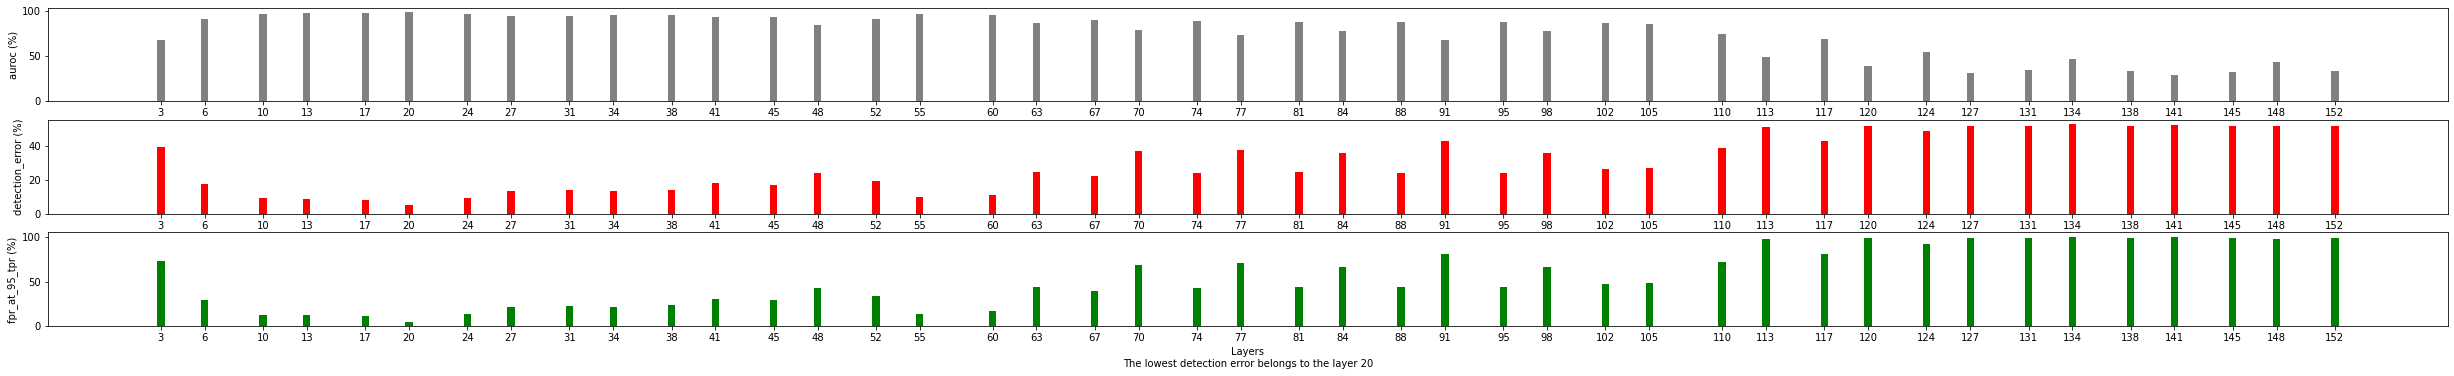

The lowest detection error belongs to the layer  20


In [25]:
x = slc_layers
bar_size=0.5
row_size = 5
figsize=(len(slc_layers),10)
fig = plt.figure(1, figsize=figsize)

plt.subplot(row_size, 1, 3)
plt.bar(x, auroc, width=bar_size, color="gray")
plt.ylabel('auroc (%)')
plt.xticks(x)

plt.subplot(row_size, 1, 4)
plt.bar(x, detection_error, width=bar_size, color="red")
plt.ylabel('detection_error (%)')
plt.xticks(x)

plt.subplot(row_size, 1, 5)
plt.bar(x, fpr_at_95_tpr, width=bar_size, color="green")
plt.ylabel('fpr_at_95_tpr (%)')
plt.xticks(x)

plt.xlabel('Layers\n'+"The lowest detection error belongs to the layer "+\
                           str(slc_layers[np.argmin(detection_error)]))
plt.show()
print("The lowest detection error belongs to the layer ", str(slc_layers[np.argmin(detection_error)]))
fig.savefig(base_address+id_name+"-"+id_model+"-"+ood_ds_name+".png")